In [151]:
from time import time
import os, sys, fitsio, datetime
from astropy import units
from astropy.io import fits
from astropy.coordinates import SkyCoord
import numpy as np
from math import pi,cos,sin
from astropy.table import Table, Column
import matplotlib.pyplot as plt
from glob import glob
from collections import Counter
import desimodel.focalplane
import desimodel.footprint
from desitarget.targetmask import desi_mask, obsconditions
import random,fitsio
from desimodel.io import (load_desiparams, load_fiberpos, load_platescale,load_tiles, load_deviceloc)
import pylab as py
from matplotlib import gridspec
from matplotlib.patches import Circle
#from desiutil.plots import init_sky, plot_healpix_map, p lot_grid_map, plot_sky_circles, plot_sky_binned, prepare_data


In [207]:
path= '/uufs/chpc.utah.edu/common/home/bolton-group1/bolton_data2/kdawson/sarahE/eboss/cat/'
qscat='eBOSS_QSO_hod_utah_eboss_SGC_v7_trimm_legacy_no-obs.dat.fits'
qncat='eBOSS_QSO_hod_utah_eboss_NGC_v7_trimm_legacy_no-obs.dat.fits'

nq =fitsio.read(path+qncat)
ns = fitsio.read(path+qscat)
q = np.concatenate((nq,ns),axis=0)
len(q)


504874

In [208]:
import healpy as hp

### set pixeled map resolution 
nside = 16
print("Approximate resolution at nside {} is {:.2} deg".format(
        nside, hp.nside2resol(nside, arcmin=True) / 60))

NPIX = hp.nside2npix(nside)
print('Number of pixels given the resolution:',NPIX)
print((hp.ang2pix(32,45*pi/180,90*pi/180.)))

Approximate resolution at nside 16 is 3.7 deg
Number of pixels given the resolution: 3072
1770


In [209]:
theta = []
for i in range(len(q)):
    if q['RA'][i]*pi/180 < np.pi:
         theta.append(q['RA'][i]*pi/180)
    else:
         theta.append(q['RA'][i]*pi/180-pi)

pix=hp.ang2pix(16,theta,phi=list(q['DEC']*pi/180.))
print(np.min(pix),np.max(pix),len(np.unique(pix)))

0 3071 303


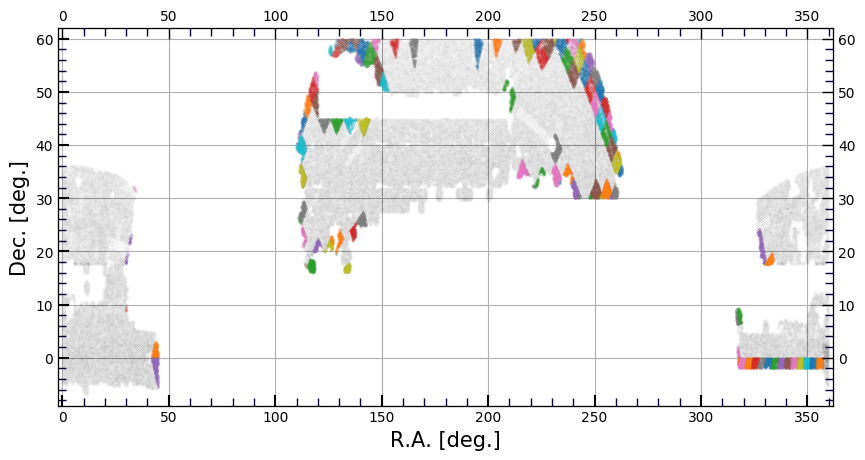

Median population of each pixel: 1651.0
With nside 16 there are 115 pixels (out of 303) with population less than two-thirds of the median population


In [210]:
fig = py.figure(figsize=(10, 5), dpi=100)
ax= fig.add_subplot(111)

ofs=2
xlim = (np.min(q['RA'])-ofs,np.max(q['RA'])+ofs )
ylim = (np.min(q['DEC'])-ofs,np.max(q['DEC'])+ofs )

pixels = np.unique(pix)
pix_pop = []
low_pop_pix = []
low_pop_pop = []
good_pix = []
good_pix_pop =[]
lowpop_ra = []
lowpop_dec = []

for p in pixels:
   
   pind = (pix ==p)
   if len(q['RA'][pind]) < 1600*2/3.:
    
       py.plot(q['RA'][pind],q['DEC'][pind],marker='.',markersize=0.1,linestyle='')
       low_pop_pix.append(p) 
       low_pop_pop.append(len(q['RA'][pind]))
       lowpop_ra += list(q['RA'][pind])
       lowpop_dec += list(q['DEC'][pind])

   else:
       good_pix.append(p)
       py.plot(q['RA'][pind],q['DEC'][pind],marker='.',markersize=0.1,linestyle='',color='gray',alpha=0.1) 
       good_pix_pop.append(len(q['RA'][pind]))
       
   pix_pop.append(len(q['RA'][pind]))
   
ax.set_xlim(xlim)
ax.set_ylim(ylim)

#ax.set_title(plot_title)
ax.set_xlabel('R.A. [deg.]',fontsize=15)
ax.set_ylabel('Dec. [deg.]',fontsize=15)
ax.minorticks_on()
ax.tick_params(which='major', length=8, width=1.5, direction='in') 
ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')        

x_ax = ax.twiny()
x_ax.minorticks_on()
x_ax.tick_params(which='major', length=8, width=1.0, direction='in')
x_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')     
x_ax.tick_params()
y_ax= plt.twinx()
y_ax.minorticks_on()
x_ax.set_xlim(xlim)
y_ax.set_ylim(ylim)
y_ax.tick_params(which='major', length=8, width=1.0, direction='in')
y_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')     
#pylab.savefig(path+output_filename)
ax.grid()
plt.show()
print("Median population of each pixel: {}".format(np.median(good_pix_pop)))

lowpop = np.sum(pix_pop < np.median(good_pix_pop)*2/3.)
print('With nside {} there are {} pixels (out of {}) with population less than two-thirds of the median population'.format(nside,lowpop, len(pixels)))
      


In [211]:
theta_low = []
for i in range(len(lowpop_ra)):
    if lowpop_ra[i]*pi/180 < np.pi:
         theta_low.append(lowpop_ra[i]*pi/180)
    else:
         theta_low.append(lowpop_ra[i]*pi/180-pi)

lpix = hp.ang2pix(4,theta_low,list(np.asarray(lowpop_dec)*pi/180.))
print(np.min(lpix),np.max(lpix),len(np.unique(lpix)))
                  

0 191 31


In [135]:
n=5
p=[]
for i in range(len(low_pop_pix)):
    j = i*n
    if sum(low_pop_pop[j:j+n]) > 2*1651./3:
       print(low_pop_pix[j:(j+n)],sum(low_pop_pop[j:j+n]))
       low_pop_pix[j:(j+n)] = list(np.repeat(low_pop_pix[j],len(low_pop_pix[j:(j+n)])))
       p.append(low_pop_pix[j])
    else:
        n= n+1
        continue
print(p)        

[43, 117, 185, 221, 222] 2220
[227, 268, 316, 320, 368] 2268
[373, 420, 425, 429, 479] 3326
[490, 550, 551, 555, 613] 2734
[618, 678, 682, 683, 741] 3024
[745, 746, 805, 810, 811] 2236
[873, 874, 933, 937, 938] 2587
[997, 1000, 1001, 1061, 1064] 3499
[1065, 1125, 1127, 1128, 1189] 3580
[1191, 1192, 1253, 1254, 1255] 3258
[2281, 2344, 2403, 2410, 2467, 2468] 2057
[2472, 2474, 2475, 2538, 2592, 2593] 1984
[2594, 2599, 2601, 2651, 2653, 2655] 2390
[2660, 2661, 2707, 2711, 2714, 2715] 2826
[2716, 2759, 2767, 2807, 2810, 2814] 5039
[2815, 2851, 2853, 2857, 2891, 2893] 2464
[2927, 2933, 2959, 2987, 3011, 3015] 3587
[3031, 3047, 3059, 3067] 2500
[43, 227, 373, 490, 618, 745, 873, 997, 1065, 1191, 2281, 2472, 2594, 2660, 2716, 2815, 2927, 3031]


58120 209


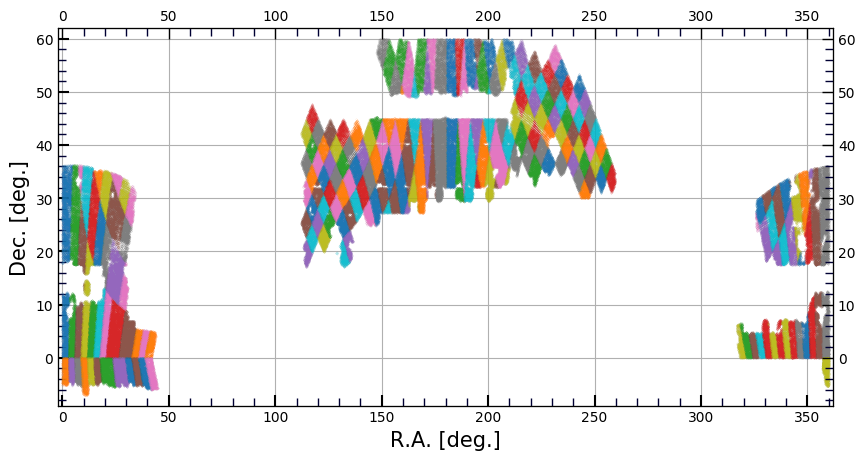

193


In [218]:
fig = py.figure(figsize=(10, 5), dpi=100)
ax= fig.add_subplot(111)

ofs=2
xlim = (np.min(q['RA'])-ofs,np.max(q['RA'])+ofs )
ylim = (np.min(q['DEC'])-ofs,np.max(q['DEC'])+ofs )
#pixels = low_pop_pix+ good_pix    #225 pixels--> method 1 where same nside=16 was used just merging every 5 pixels in the list together 
pixels = list(lpix)+ good_pix     #209 pixels--> preferred: method 2 where nside=4 was used for the ra/dec of targets that were in low populated pixels so they sit togetehr in larger pixels 
print(len(pixels),len(np.unique(pixels)))
pix_pop=[]
newpix = np.zeros(len(pix))-1
for p in np.unique(pixels):
   
   pind = (pix ==p)
    
   py.plot(q['RA'][pind],q['DEC'][pind],marker='.',markersize=0.1,linestyle='')
   newpix[pind] = np.repeat(p,len(q['RA'][pind]))
    
   pix_pop.append(p)
       
   
ax.set_xlim(xlim)
ax.set_ylim(ylim)

#ax.set_title(plot_title)
ax.set_xlabel('R.A. [deg.]',fontsize=15)
ax.set_ylabel('Dec. [deg.]',fontsize=15)
ax.minorticks_on()
ax.tick_params(which='major', length=8, width=1.5, direction='in') 
ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')        

x_ax = ax.twiny()
x_ax.minorticks_on()
x_ax.tick_params(which='major', length=8, width=1.0, direction='in')
x_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')     
x_ax.tick_params()
y_ax= plt.twinx()
y_ax.minorticks_on()
x_ax.set_xlim(xlim)
y_ax.set_ylim(ylim)
y_ax.tick_params(which='major', length=8, width=1.0, direction='in')
y_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')     
#pylab.savefig(path+output_filename)
ax.grid()
plt.show()
print(len(np.unique(newpix)))

In [217]:
len(np.unique(pix_pop))

209

In [185]:
### write down the file for Faizan
outpath= '/uufs/chpc.utah.edu/common/home/bolton-group1/bolton_data2/kdawson/sarahE/eboss/'
a=Table(q)
col = Column(newpix,name='PIXEL',dtype='i8')
a.add_column(col,index=0)
a.write(outpath+'eBOSS_QSO_hod_utah_eboss_SGC_v7_trimm_legacy_no-obs.dat_PIXELED.fits')

In [205]:
b=fitsio.read(outpath+'eBOSS_QSO_hod_utah_eboss_NGC+SGC_v7_trimm_legacy_no-obs.dat_PIXELED.fits')

In [206]:
len(np.unique(b['PIXEL']))

193